### Iterative hard thresholding with unit step size

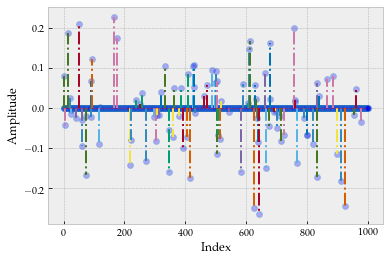

In [9]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import brewer

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import random
from numpy import linalg as la

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

p = 1000  # Ambient dimension
n = 200   # Number of samples
k = 100   # Sparsity level

# Generate a p-dimensional zero vector
x_star = np.zeros(p)
# Randomly sample k indices in the range [1:p]
x_star_ind = random.sample(range(p),  k) 
# Set x_star_ind with k random elements from Gaussian distribution
x_star[x_star_ind] = np.random.randn(k)
# Normalize
x_star = (1 / la.norm(x_star, 2)) * x_star

# Plot
plt.style.use('bmh')
xs = range(p)
markerline, stemlines, baseline = plt.stem(xs, x_star, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

# Generate sensing matrix
Phi = (1 / math.sqrt(n)) * np.random.randn(n, p)

# Observation model
y = Phi @ x_star

In [10]:
# Hard thresholding function
def hardThreshold(x, k):
    p = x.shape[0]
    t = np.sort(np.abs(x))[::-1]    
    threshold = t[k-1]
    j = (np.abs(x) < threshold)
    x[j] = 0
    return x

# Returns the value of the objecive function
def f(y, A, x):
    return 0.5 * math.pow(la.norm(y - Phi @ x, 2), 2)

def IHT(y, A, k, eta, iters, epsilon, verbose, x_star):
    # Length of original signal
    p = A.shape[1]
    # Length of measurement vector
    n = A.shape[0]
    # Initial estimate
    x_new = np.zeros(p)    
    # Transpose of A
    At = np.transpose(A)

    # Initialize
    x_new = np.zeros(p)           # The algorithm starts at x = 0

    PhiT = np.transpose(Phi)
    
    x_list, f_list = [1], [f(y, Phi, x_new)]

    for i in range(iters):
        x_old = x_new
    
        # Compute gradient
        grad = -PhiT @ (y - Phi @ x_new)
    
        # Perform gradient step
        x_temp = x_old - eta * grad    
    
        # Perform hard thresholding step
        x_new = hardThreshold(x_temp, k)
    
        if (la.norm(x_new - x_old, 2) / la.norm(x_new, 2)) < epsilon:
            break
                
        # Keep track of solutions and objective values
        x_list.append(la.norm(x_new - x_star, 2))
        f_list.append(f(y, Phi, x_new))
        
        if verbose:
            print("iter# = "+ str(i) + ", ||x_new - x_old||_2 = " + str(la.norm(x_new - x_old, 2)))
    
    print("Number of steps:", len(f_list))
    return x_new, x_list, f_list

iter# = 0, ||x_new - x_old||_2 = 0.17591618413774357
iter# = 1, ||x_new - x_old||_2 = 0.10795860931193638
iter# = 2, ||x_new - x_old||_2 = 0.06883888363996764
iter# = 3, ||x_new - x_old||_2 = 0.04666840782053313
iter# = 4, ||x_new - x_old||_2 = 0.034255683799553426
iter# = 5, ||x_new - x_old||_2 = 0.02721692805789281
iter# = 6, ||x_new - x_old||_2 = 0.02634555062250662
iter# = 7, ||x_new - x_old||_2 = 0.025429654369206564
iter# = 8, ||x_new - x_old||_2 = 0.02625282894846146
iter# = 9, ||x_new - x_old||_2 = 0.020762043987875248
iter# = 10, ||x_new - x_old||_2 = 0.018858835751686794
iter# = 11, ||x_new - x_old||_2 = 0.020326323131331835
iter# = 12, ||x_new - x_old||_2 = 0.019377525508266567
iter# = 13, ||x_new - x_old||_2 = 0.019219458483754646
iter# = 14, ||x_new - x_old||_2 = 0.015741422334113374
iter# = 15, ||x_new - x_old||_2 = 0.019458650408049873
iter# = 16, ||x_new - x_old||_2 = 0.014932434229122141
iter# = 17, ||x_new - x_old||_2 = 0.0134840312837271
iter# = 18, ||x_new - x_old||

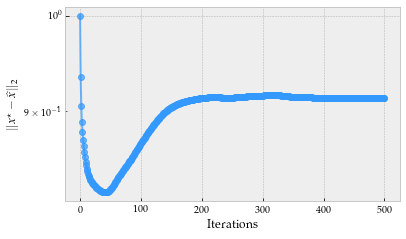

In [11]:
# Run algorithm
epsilon = 1e-6                # Precision parameter
iters = 500
# eta = 1
eta = 0.1

x_IHT, x_list, f_list = IHT(y, Phi, k, eta, iters, epsilon, True, x_star)

# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

xs = range(len(x_list))
plt.plot(xs, x_list, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()

### Iterative hard thresholding with adaptive step size

In [7]:
# Hard thresholding function
def hardThreshold2(x, k):
    p = x.shape[0]
    t = np.sort(np.abs(x))[::-1]    
    threshold = t[k-1]
    j = (np.abs(x) < threshold)
    temp = (np.abs(x) >= threshold)
    X_i = list(compress(range(len(temp)), temp))
    x[j] = 0
    return x, X_i

def adaIHT(y, A, k, iters, epsilon, verbose, x_star):
    # Length of original signal
    p = A.shape[1]
    # Length of measurement vector
    n = A.shape[0]
    # Initial estimate
    x_new = np.zeros(p)    
    # Transpose of A
    At = np.transpose(A)

    # Initialize
    x_new = np.zeros(p)           # The algorithm starts at x = 0
    X_i = []
    active_set = np.ones(p)
    
    PhiT = np.transpose(Phi)
    
    x_list, f_list = [1], [f(y, Phi, x_new)]

    for i in range(iters):
        x_old = x_new
    
        # Compute gradient    
        if (i == 0):
            grad = -PhiT @ y
        else:
            grad = -PhiT @ (y - Phi @ x_new)
    
        active_set[X_i] = 0
        grad_outside_X_i = grad * active_set
        t = np.sort(np.abs(grad_outside_X_i))[::-1]    
        threshold = t[k-1]
        j = (np.abs(grad_outside_X_i) >= threshold)
        T = list(compress(range(len(j)), j))
        Q = X_i + T
        
        # Compute step size
        eta = la.norm(grad[Q])**2 / la.norm(Phi[:, Q] @ grad[Q])**2
        
        # Perform gradient step
        x_temp = x_old - eta * grad    
    
        # Perform hard thresholding step
        x_new, X_i = hardThreshold2(x_temp, k)        
    
        if (la.norm(x_new - x_old, 2) / la.norm(x_new, 2)) < epsilon:
            break
                
        # Keep track of solutions and objective values
        x_list.append(la.norm(x_new - x_star, 2))
        f_list.append(f(y, Phi, x_new))
        
        if verbose:
            print("iter# = "+ str(i) + ", ||x_new - x_old||_2 = " + str(la.norm(x_new - x_old, 2)))
    
    print("Number of steps:", len(f_list))
    return x_new, x_list, f_list

iter# = 0, ||x_new - x_old||_2 = 0.15091400431769303
iter# = 1, ||x_new - x_old||_2 = 0.11192428262994045
iter# = 2, ||x_new - x_old||_2 = 0.0840103110731047
iter# = 3, ||x_new - x_old||_2 = 0.06409237612126704
iter# = 4, ||x_new - x_old||_2 = 0.04993114283527505
iter# = 5, ||x_new - x_old||_2 = 0.03988861819383657
iter# = 6, ||x_new - x_old||_2 = 0.03276134656294098
iter# = 7, ||x_new - x_old||_2 = 0.027667441136602272
iter# = 8, ||x_new - x_old||_2 = 0.023969802638111895
iter# = 9, ||x_new - x_old||_2 = 0.021219626155314076
iter# = 10, ||x_new - x_old||_2 = 0.019110083982566122
iter# = 11, ||x_new - x_old||_2 = 0.017436978091331802
iter# = 12, ||x_new - x_old||_2 = 0.02571404855761337
iter# = 13, ||x_new - x_old||_2 = 0.019152379295870003
iter# = 14, ||x_new - x_old||_2 = 0.01756968799376285
iter# = 15, ||x_new - x_old||_2 = 0.01620193590211761
iter# = 16, ||x_new - x_old||_2 = 0.01500814221972375
iter# = 17, ||x_new - x_old||_2 = 0.02041253689311781
iter# = 18, ||x_new - x_old||_2 =

iter# = 149, ||x_new - x_old||_2 = 1.3259684925134444e-06
iter# = 150, ||x_new - x_old||_2 = 1.1725879886815577e-06
iter# = 151, ||x_new - x_old||_2 = 1.0269863148696805e-06
iter# = 152, ||x_new - x_old||_2 = 8.995659050009248e-07
iter# = 153, ||x_new - x_old||_2 = 7.865350538301883e-07
iter# = 154, ||x_new - x_old||_2 = 6.892444010021877e-07
iter# = 155, ||x_new - x_old||_2 = 6.039791225002461e-07
iter# = 156, ||x_new - x_old||_2 = 5.305593211656451e-07
iter# = 157, ||x_new - x_old||_2 = 4.6491327804413193e-07
iter# = 158, ||x_new - x_old||_2 = 4.0741591386965553e-07
iter# = 159, ||x_new - x_old||_2 = 3.5617451643360926e-07
iter# = 160, ||x_new - x_old||_2 = 3.1368457149036013e-07
iter# = 161, ||x_new - x_old||_2 = 2.7485224927801253e-07
iter# = 162, ||x_new - x_old||_2 = 2.3633306370477982e-07
iter# = 163, ||x_new - x_old||_2 = 2.0762461898019417e-07
iter# = 164, ||x_new - x_old||_2 = 1.8241218430260973e-07
iter# = 165, ||x_new - x_old||_2 = 1.6026842730743186e-07
iter# = 166, ||x_ne

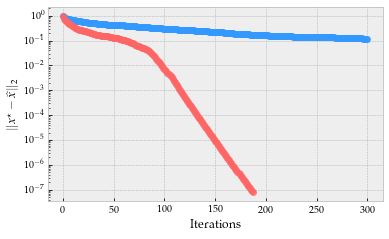

In [8]:
from itertools import compress

# Run algorithm
epsilon = 1e-8                # Precision parameter
iters = 300
eta = 0.1

x_IHT, x_list, f_list = IHT(y, Phi, k, eta, iters, epsilon, True, x_star)
x_adaIHT, x_adalist, f_adalist = adaIHT(y, Phi, k, iters, epsilon, True, x_star)

# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

xs_IHT = range(len(x_list))
xs_adaIHT = range(len(x_adalist))

plt.plot(xs_IHT, x_list, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7)
plt.plot(xs_adaIHT, x_adalist, '-o', color = '#FF6666', linewidth = 2, alpha = 0.7)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()

### Under-/Over-shooting sparsity level

In [ ]:
from itertools import compress

# Run algorithm
epsilon = 1e-8                # Precision parameter
iters = 300
eta = 0.1
k = 40

x_IHT, x_list, f_list = IHT(y, Phi, k, eta, iters, epsilon, True, x_star)
x_adaIHT, x_adalist, f_adalist = adaIHT(y, Phi, k, iters, epsilon, True, x_star)

# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

xs_IHT = range(len(x_list))
xs_adaIHT = range(len(x_adalist))

plt.plot(xs_IHT, x_list, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7)
plt.plot(xs_adaIHT, x_adalist, '-o', color = '#FF6666', linewidth = 2, alpha = 0.7)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()

In [ ]:
# Plot
plt.style.use('bmh')
xs = range(p)
markerline, stemlines, baseline = plt.stem(xs, x_star, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

# Plot
plt.style.use('bmh')
xs = range(p)
markerline, stemlines, baseline = plt.stem(xs, x_IHT, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

# Plot
plt.style.use('bmh')
xs = range(p)
markerline, stemlines, baseline = plt.stem(xs, x_adaIHT, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()
